In [51]:
import numpy as np
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib
import json, math
import polars as pl
from operator import sub
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

In [52]:
pd_target = 0.99
pex_target = 0.01

def get_reward(pd, pex):
    if pd <= pd_target and pex >= pex_target:
        a = pd/pd_target
        b = (1-pex) / (1-pex_target)
        return 0.5 * a * a * b * b


    if pd > pd_target and pex >= pex_target:
        a = 1.0
        b = (1-pex) / (1-pex_target)
        return 0.5 * a * a * b * b


    if pd <= pd_target and pex < pex_target:
        a = pd/pd_target
        b = 1.0
        return 0.5 * a * a * b * b


    if pd > pd_target and pex < pex_target:
        a = (pd - pd_target) / (1-pd_target)
        b = (pex_target-pex) / pex_target
        return 0.5 + 0.5 * a * b
    

    return 0

In [53]:
loss_df = pl.DataFrame()
reward_df = pl.DataFrame()
n = 200
v= 50

errs = 0

for i in np.arange(30, 300, 5):
    for q in np.arange(0, 300, 5):
        for r in range(40):
            try:
                with open(f'../res/v{v}_parsed/summary_kpi_rdf_n{n}_i{i}_q{q}_r{r}.json', 'r') as f:
                    data = json.load(f)
                    avg_loss_rate = data['avg_loss_rate']
                
                    loss_df = pl.concat([loss_df, pl.DataFrame({
                        'i': i,
                        'q': q,
                        'avg_loss_rate': avg_loss_rate
                    })])
            except:
                errs+=1

            try:
                df_curr = pl.read_csv(f'../res/v49/kpi_rdf_n{n}_i{i}_q{q}_r{r}.csv')
                reward = get_reward(df_curr['pd'][0],df_curr['pe500'][0])
                reward_df = pl.concat([reward_df, pl.DataFrame({
                    'i': i,
                    'q': q,
                    'reward': reward,
                })])
            except:
                errs+=1


In [54]:
step = 5
i_pos = list(np.arange(30, 300, step))
q_pos = list(np.arange(0, 300, step) / 100)

def get_pd(i,q,H):
    try:
        df = pl.read_csv(f'../analytical_results/v117/pd_analytic_n{n}_H{H}_i{int(i)}_q{int(q*100)}.csv')
        return df['pd_v1'].to_numpy()[0]
    except:
        return 0

def get_pd_matrix(H):
    p_d = np.zeros((len(q_pos), len(i_pos)))

    for idx1, i in enumerate(i_pos):
        for idx2, q in enumerate(q_pos):
            p_d[idx2][idx1] = get_pd(i,q,H)
    return p_d

In [55]:
p_d_analytic = np.zeros((len(q_pos), len(i_pos)))

hop_dist_df = pl.read_csv(f'../analytical_results/hop_dist/hop_distribution_n{n}.csv')

prob = hop_dist_df['prob'].to_numpy()

for i in range(1, len(prob)):
    try:
        p = prob[i]
        p_d_analytic = p_d_analytic + p * get_pd_matrix(i)
    except:
        pass

In [56]:
aoi_target = 736 # ms

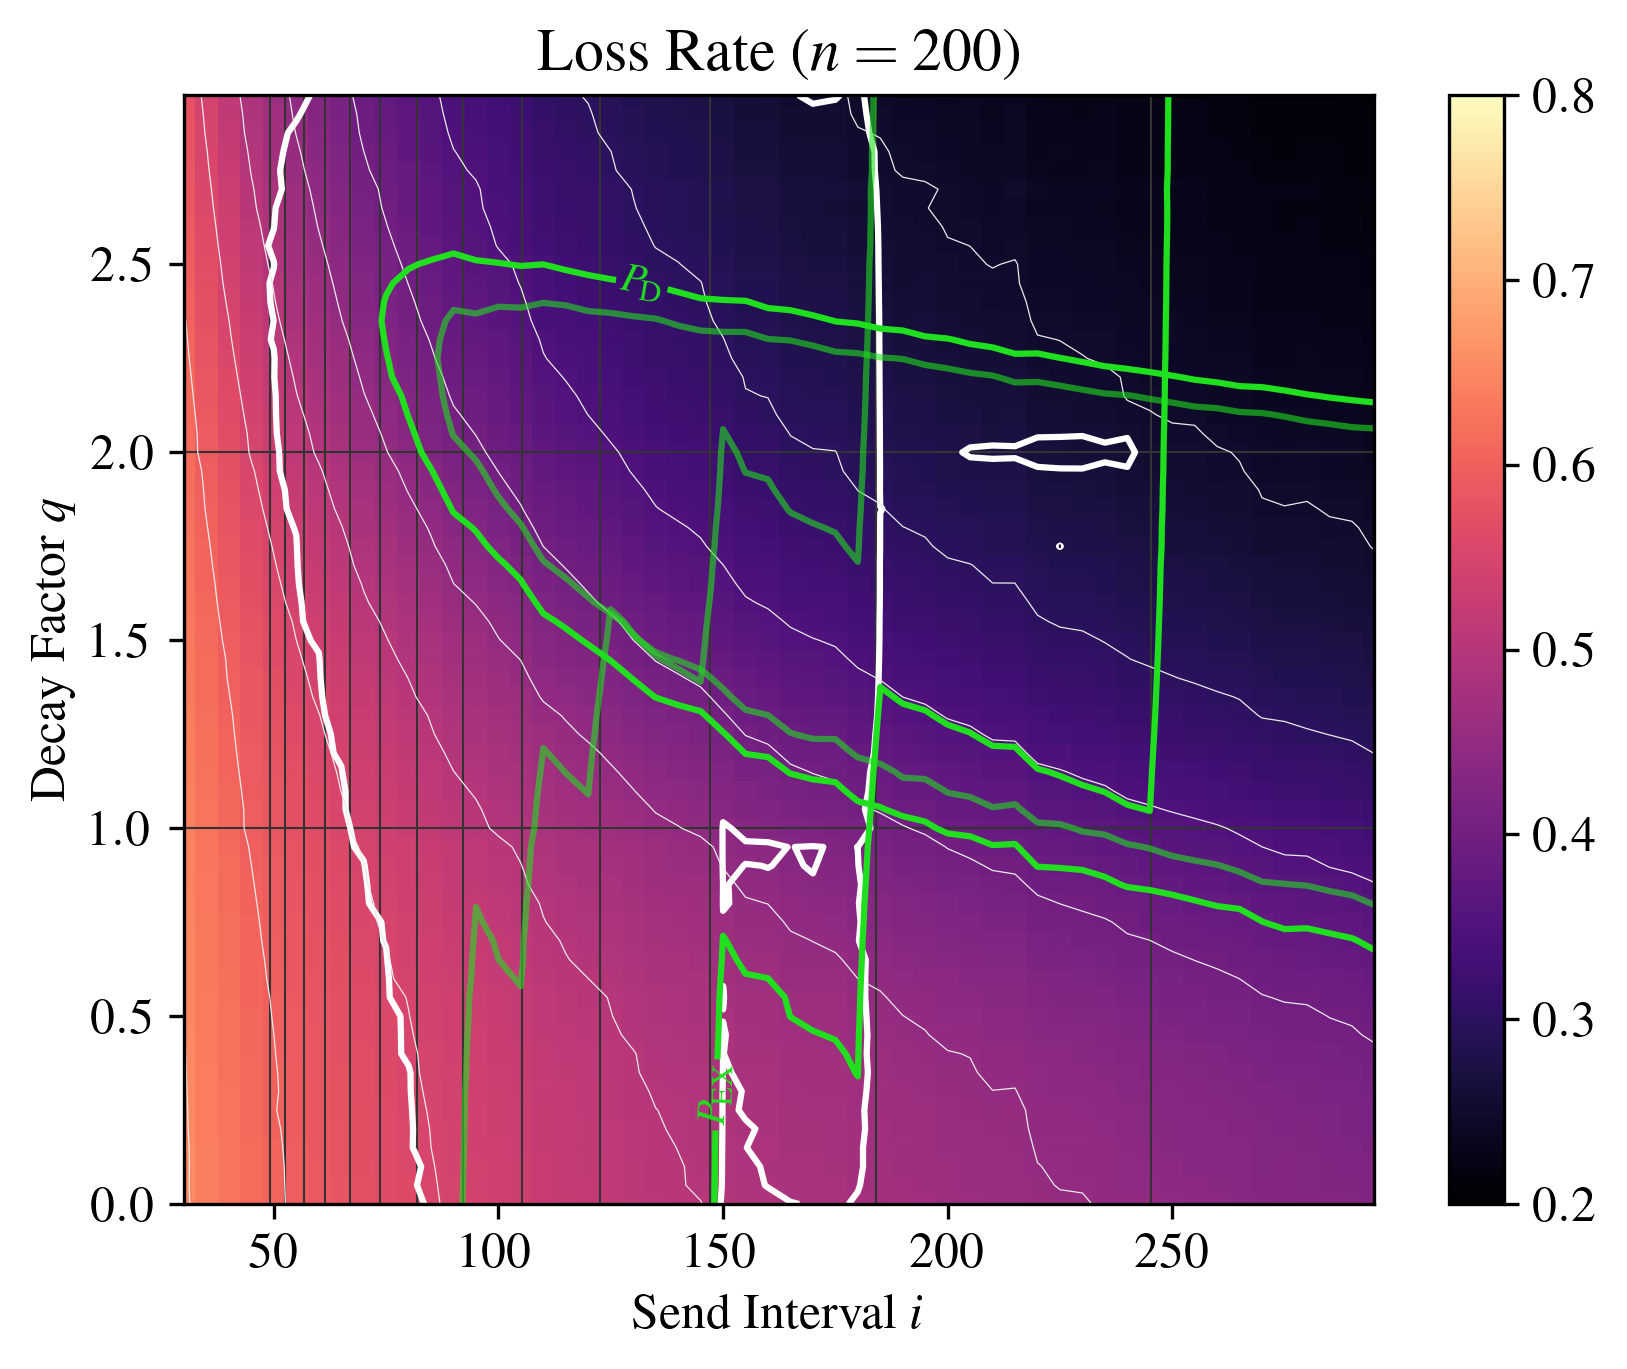

In [57]:
fig, ax = plt.subplots()
# ax.plot([0],[0])
ax.set_ylim([0, 2.95])
ax.set_xlim([30, 295])

gs = 30

X_L = loss_df['i'].to_numpy()
Y_L = loss_df['q'].to_numpy() / 100
X_R = reward_df['i'].to_numpy()
Y_R = reward_df['q'].to_numpy() / 100
R = reward_df['reward'].to_numpy()
L = loss_df['avg_loss_rate'].to_numpy()

for f in range(3, 16):
    ax.plot([aoi_target / f, aoi_target / f], [0, 200], color='#333', lw = 0.5)


ax.plot([0, 300], [1, 1], color='#333', lw = 0.5)
ax.plot([0, 300], [2, 2], color='#333', lw = 0.5)


step = 5
i_bins = list(np.arange(30-step/2, 300+step/2, step))
q_bins = list(np.arange(0-step/2, 300+step/2, step) / 100)
i_pos = list(np.arange(30, 300, step))
q_pos = list(np.arange(0, 300, step) / 100)
ret = scipy.stats.binned_statistic_2d(X_R, Y_R, R, 'mean', bins=[i_bins,q_bins])
cntr = ax.contour(i_pos, q_pos, np.swapaxes(ret.statistic, axis1=0, axis2=1), [0.5], colors='#fff')
#cmap=cm.gray, vmin=0.5, vmax=0.9
#ax.clabel(cntr, [0.5])
ret = scipy.stats.binned_statistic_2d(X_L, Y_L, L, 'mean', bins=[i_bins,q_bins])

losses = np.swapaxes(ret.statistic, axis1=0, axis2=1)
cntr = ax.contour(i_pos, q_pos, losses, 10, colors='#ebebeb', linewidths=0.3)
pcm = ax.pcolormesh(
    i_pos, 
    q_pos, 
    losses, 
    vmin=0.2,
    vmax=0.8,
    cmap=cm.magma,
    linewidth=0,
    rasterized=True
)
fig.colorbar(pcm, ax=ax)

L = math.sqrt(n/12)
T = L*1000 / 33.3
H = math.ceil(L / 0.509)


ii, qq = np.meshgrid(i_pos, q_pos)

# K_1 = 1
# K_2 = 1
# alpha = 0.55

# delay = ii 
# for h in range(2,H+1):
#     delay = delay + ii * np.power(H,qq)
f = 0.6
P_L_EX = np.power(0.01, 1/(np.floor(aoi_target / ii)))
P_L_EX_v2 = -(1-f) / (2*f) + np.sqrt((1-f)**2/(4 * f**2) + P_L_EX/f)

p_d_analytic_v2 = -(1-f) / (2*f) + np.sqrt((1-f)**2/(4 * f**2) + p_d_analytic/f)


# P_L_EX = (alpha -1) / (2 * alpha) + np.sqrt(np.power((1-alpha)/(2 * alpha),2) + P_L_EX / alpha)
# num_attempts = K_2* np.maximum(np.floor((T*1000 - delay /2 ) / ii),1)
# P_L_D = 1- np.power(1-np.power(0.01, 1/num_attempts),1/H)
# P_L = np.minimum(P_L_D, P_L_EX)

# m = P_L - np.swapaxes(ret.statistic, axis1=0, axis2=1),
m_EX = np.swapaxes(ret.statistic, axis1=0, axis2=1) - P_L_EX 
m_EX_v2 = np.swapaxes(ret.statistic, axis1=0, axis2=1) - P_L_EX_v2
m_D = p_d_analytic - 0.99
m_D_v2 = p_d_analytic_v2 - 0.99


# cntr = ax.contour(i_pos, q_pos, m_EX * m_D, [0], colors='#20DF1E')
cntr = ax.contour(i_pos, q_pos, m_EX, [0], colors='#20DF1E', alpha=0.6)
cntr = ax.contour(i_pos, q_pos, m_EX_v2, [0], colors='#20DF1E')
ax.clabel(cntr, cntr.levels, inline=True, fmt=lambda x: "$P_\mathrm{EX}$", fontsize=10, manual=[(120, 0.3)])
cntr = ax.contour(i_pos, q_pos, m_D, [0], colors='#20DF1E', alpha=0.6)
cntr = ax.contour(i_pos, q_pos, m_D_v2, [0], colors='#20DF1E')
ax.clabel(cntr, cntr.levels, inline=True, fmt=lambda x: "$P_\mathrm{D}$", fontsize=10, manual=[(140, 3)])


# ax.set_xscale('log')
# ax.set_xticks([aoi_target / 3, aoi_target / 4, aoi_target / 5, aoi_target / 6, aoi_target / 7, aoi_target / 8, aoi_target / 9])
# ax.set_xticklabels(['$i_0/3$', '$i_0/4$', '$i_0/5$', '$i_0/6$', '$i_0/7$', '$i_0/8$', '$i_0/9$'])


ax.set_ylabel('Decay Factor $q$')
ax.set_xlabel('Send Interval $i$')
plt.title(f'Loss Rate ($n={n}$)')

fig.savefig(f"../figures/loss_rate_vs_config_n{n}_v2.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/loss_rate_vs_config_n{n}_v2.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
# ax.grid()

plt.show()

In [58]:
H

9

In [59]:
df = pl.DataFrame()
for idx1, i in enumerate(i_pos):
    for idx2, q in enumerate(q_pos):
        # print(i, q, losses[idx2][idx1])
        df = df.vstack(pl.DataFrame({
            'i': i,
            'q': q,
            'p_L': losses[idx2][idx1]
        }))

df.write_csv(f'../loss_traces_n{n}.csv')
print(df)

shape: (3240, 3)
┌─────┬──────┬──────────┐
│ i   ┆ q    ┆ p_L      │
│ --- ┆ ---  ┆ ---      │
│ i64 ┆ f64  ┆ f64      │
╞═════╪══════╪══════════╡
│ 30  ┆ 0.0  ┆ 0.653858 │
│ 30  ┆ 0.05 ┆ 0.653366 │
│ 30  ┆ 0.1  ┆ 0.653637 │
│ 30  ┆ 0.15 ┆ 0.653499 │
│ ... ┆ ...  ┆ ...      │
│ 295 ┆ 2.8  ┆ 0.212696 │
│ 295 ┆ 2.85 ┆ 0.209548 │
│ 295 ┆ 2.9  ┆ 0.208541 │
│ 295 ┆ 2.95 ┆ 0.207852 │
└─────┴──────┴──────────┘


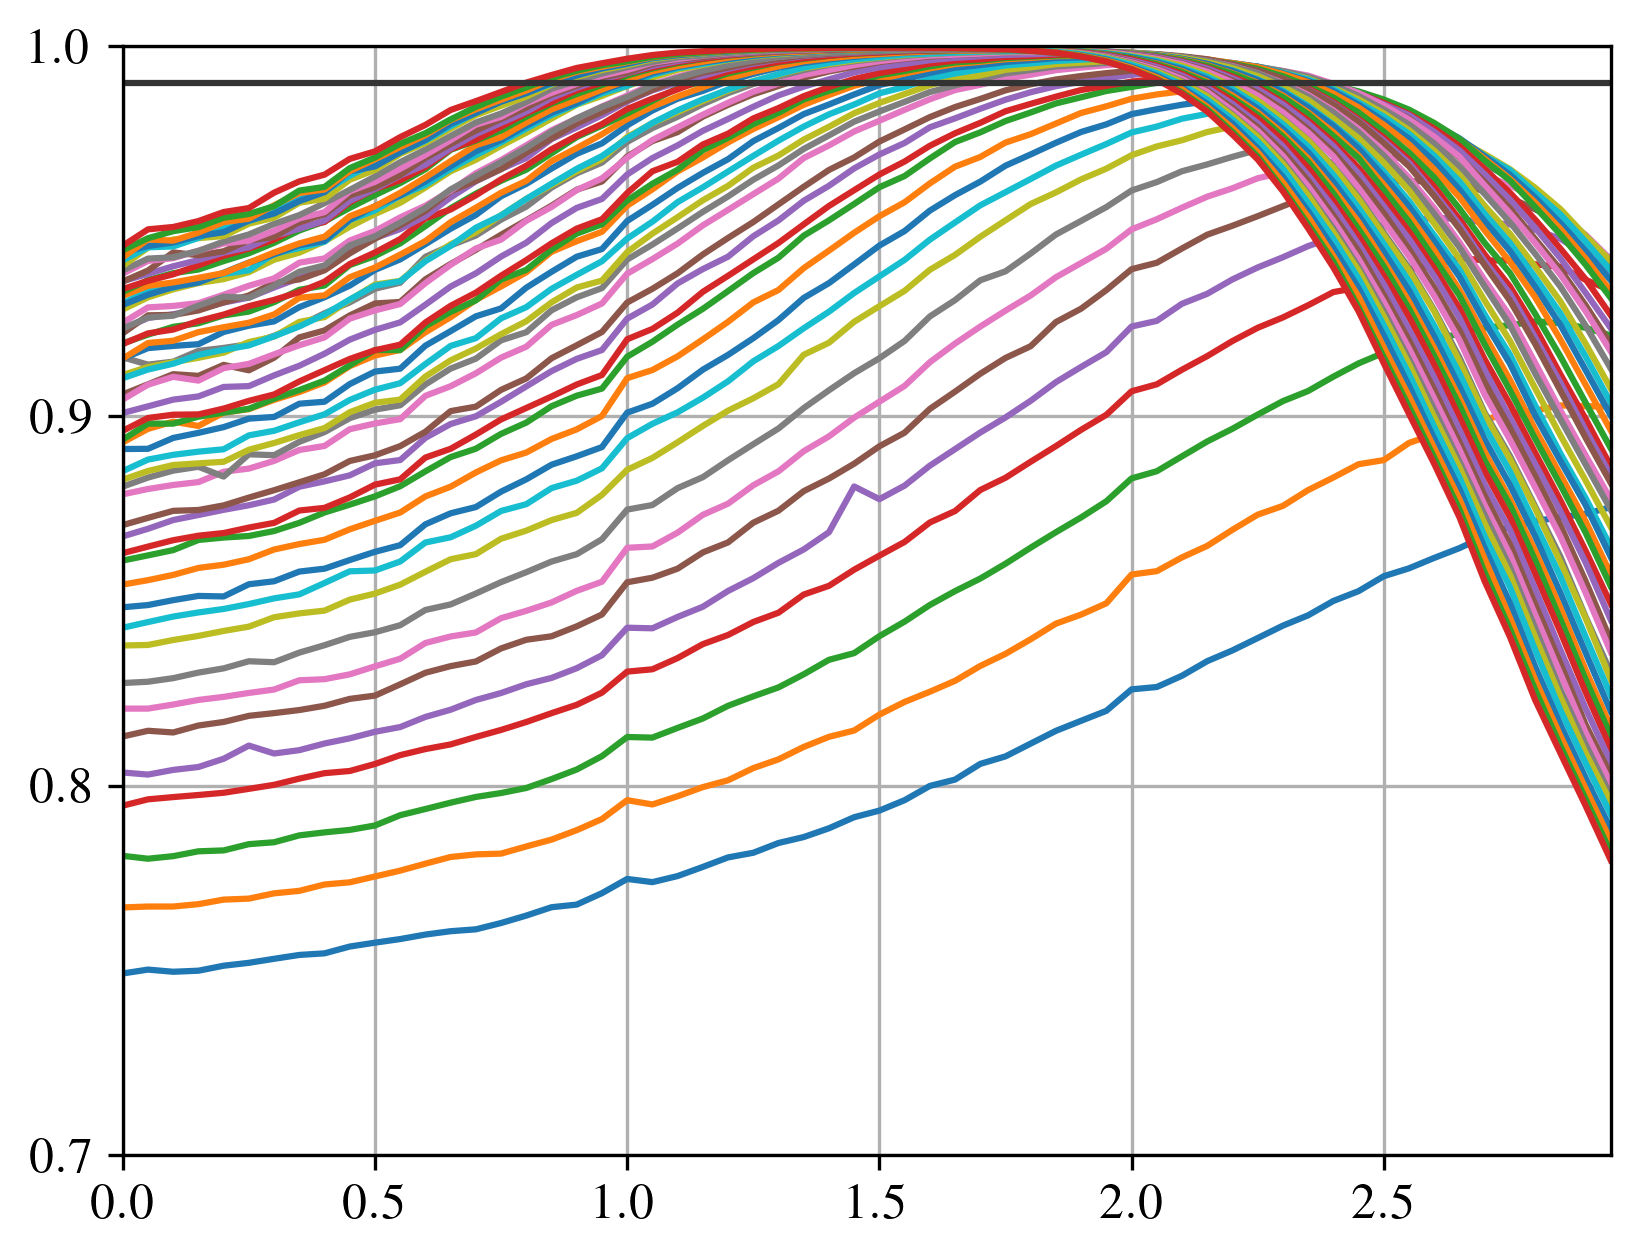

In [60]:
plt.plot(q_pos, p_d_analytic)
plt.grid()
plt.yticks(np.arange(0,1.1,0.1))
plt.ylim([0.7,1])
plt.xlim([0, 2.95])
plt.plot([0,2.95],[0.99,0.99], color='#333')
plt.show()